In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [5]:
import visual_behavior.visualization.utils as utils

import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [6]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# print(cache_dir)

In [7]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


#### add useful columns

In [8]:
experiments_table = utilities.add_cell_type_column(experiments_table)
experiments_table = utilities.add_experience_exposure_column(experiments_table)
experiments_table = utilities.add_binned_depth_column(experiments_table)

### get useful info

In [9]:
experience_level = np.sort(experiments_table.experience_level.unique())
print(experience_level)

['Familiar' 'Novel 1' 'Novel >1']


In [10]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [11]:
cell_types = np.sort(experiments_table.cell_type.unique())[::-1]
print(cell_types)

['Vip Inhibitory' 'Sst Inhibitory' 'Excitatory']


### get multi_session_df

In [12]:
%%time

# set various params
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'epoch']
use_events = True
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

multi_session_df = multi_session_df.reset_index(drop=True)

1941
1249
1249
Wall time: 1min 17s


### get rid of weird 7th epoch

In [13]:
# this epoch is <10 mins long, just a few mins over the 60 min mark for the task
multi_session_df = multi_session_df[multi_session_df.epoch!=6] # its the 6th index

### add experience_epoch column

In [14]:
def merge_experience_epoch(row):
    return row.experience_level+' epoch '+str(int(row.epoch)+1)

In [15]:
multi_session_df['experience_epoch'] = multi_session_df[['experience_level', 'epoch']].apply(axis=1, func=merge_experience_epoch)

experience_epoch = np.sort(multi_session_df.experience_epoch.unique())
experience_epoch

array(['Familiar epoch 1', 'Familiar epoch 2', 'Familiar epoch 3',
       'Familiar epoch 4', 'Familiar epoch 5', 'Familiar epoch 6',
       'Novel 1 epoch 1', 'Novel 1 epoch 2', 'Novel 1 epoch 3',
       'Novel 1 epoch 4', 'Novel 1 epoch 5', 'Novel 1 epoch 6',
       'Novel >1 epoch 1', 'Novel >1 epoch 2', 'Novel >1 epoch 3',
       'Novel >1 epoch 4', 'Novel >1 epoch 5', 'Novel >1 epoch 6'],
      dtype=object)

### before any filtering

In [16]:
df = multi_session_df.copy()
df = df.reset_index()

In [17]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  41                    280   
               Novel 1                   36                     71   
               Novel >1                  41                    196   
Sst Inhibitory Familiar                  19                    144   
               Novel 1                   15                     37   
               Novel >1                  19                    107   
Vip Inhibitory Familiar                  22                    217   
               Novel 1                   17                     47   
               Novel >1                  22                    150   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            88               18782  
               Novel 1                             71                9225  
               Novel >1                            88               15705  
Sst Inhibitory Familiar                            46                 738  
               Novel 1                             37                 414  
               Novel >1                            45                 678  
Vip Inhibitory Familiar                            69                1852  
               Novel 1                             47                 792  
               Novel >1                            66                1547

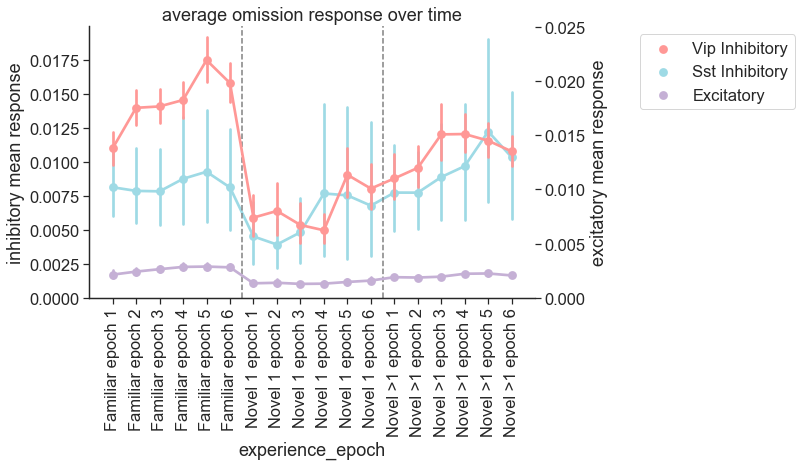

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average omission response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

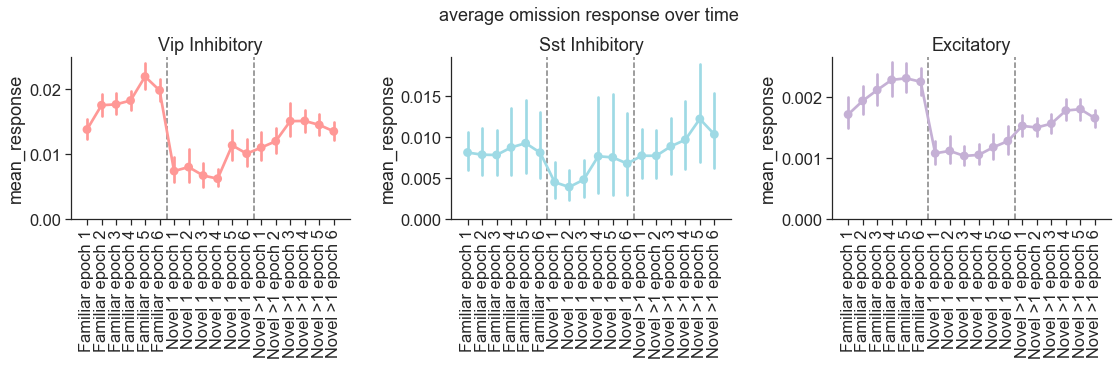

In [19]:
cre_line_colors = utils.get_cre_line_colors()
fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', 
                       order=experience_epoch, color=cre_line_colors[i], ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     if i > 0:
#         ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
plt.suptitle('average omission response over time', x=0.53, y=1.03, fontsize=18)
fig.tight_layout()

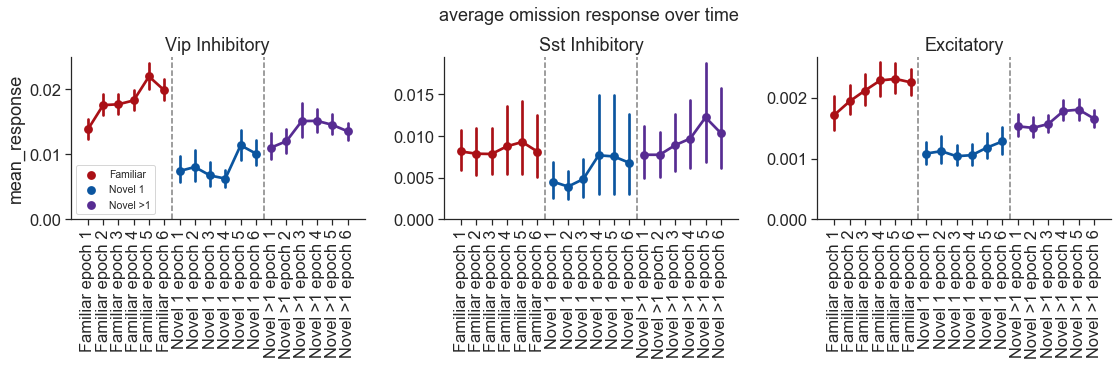

In [20]:
# cre_line_colors = utils.get_cre_line_colors()
palette = utils.get_experience_level_colors()
fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', hue='experience_level',
                       order=experience_epoch, palette=palette, ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
        ax[i].get_legend().remove()
    else:
        ax[i].legend(loc='lower left', fontsize='xx-small')
#     ax[i].set_ylim(0,0.022)
    ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
plt.suptitle('average omission response over time', x=0.53, y=1.03, fontsize=18)
fig.tight_layout()

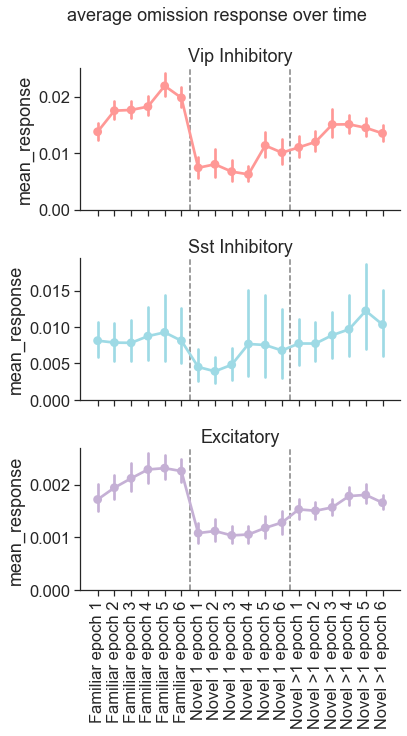

In [21]:
cre_line_colors = utils.get_cre_line_colors()
fig, ax = plt.subplots(3, 1, figsize=(6, 10), sharex=True, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', 
                       order=experience_epoch, color=cre_line_colors[i], ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
plt.suptitle('average omission response over time', x=0.53, y=1.03, fontsize=18)
fig.tight_layout()

### limit to containers with all 3 experience levels

In [22]:
df = multi_session_df.copy()
df = utilities.limit_to_containers_with_all_experience_levels(df)

In [23]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  36                    227   
               Novel 1                   36                     71   
               Novel >1                  36                    142   
Sst Inhibitory Familiar                  15                    115   
               Novel 1                   15                     37   
               Novel >1                  15                     85   
Vip Inhibitory Familiar                  17                    138   
               Novel 1                   17                     44   
               Novel >1                  17                     96   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            71               15268  
               Novel 1                             71                9225  
               Novel >1                            71               11962  
Sst Inhibitory Familiar                            37                 598  
               Novel 1                             37                 414  
               Novel >1                            37                 548  
Vip Inhibitory Familiar                            44                1233  
               Novel 1                             44                 742  
               Novel >1                            44                1067

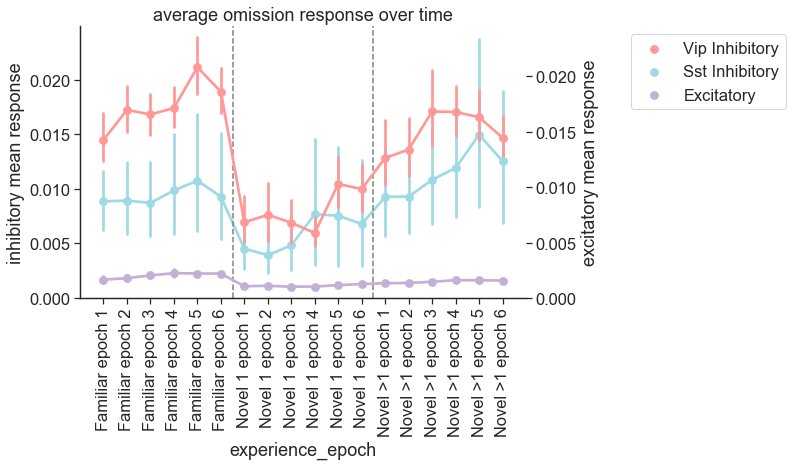

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average omission response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

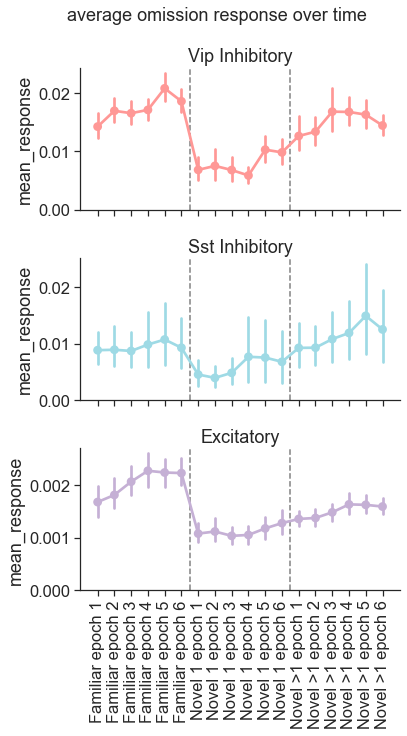

In [25]:
cre_line_colors = utils.get_cre_line_colors()
fig, ax = plt.subplots(3, 1, figsize=(6, 10), sharex=True, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', 
                       order=experience_epoch, color=cre_line_colors[i], ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
plt.suptitle('average omission response over time', x=0.53, y=1.03, fontsize=18)
fig.tight_layout()

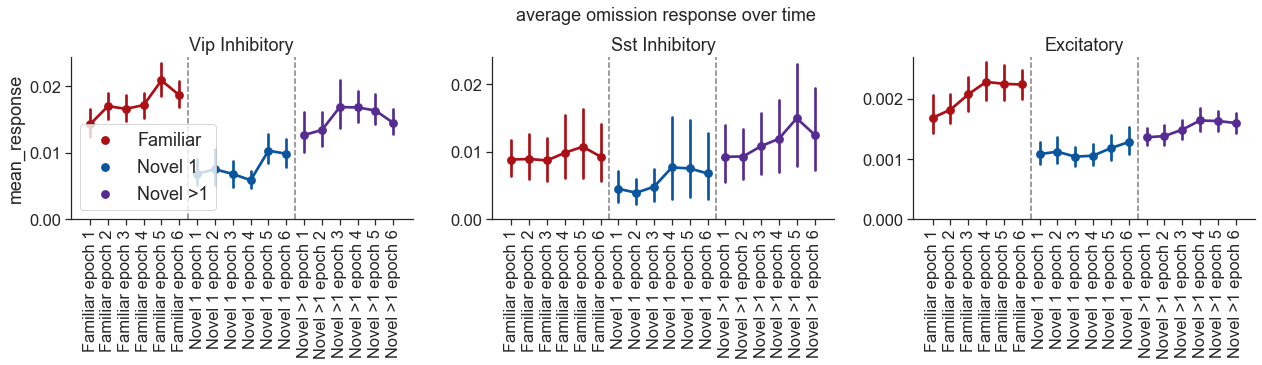

In [26]:
# cre_line_colors = utils.get_cre_line_colors()
palette = utils.get_experience_level_colors()
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', hue='experience_level',
                       order=experience_epoch, palette=palette, ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
        ax[i].get_legend().remove()
    else:
        ax[i].legend(loc='lower left', fontsize='medium')
#     ax[i].set_ylim(0,0.022)
    ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
plt.suptitle('average omission response over time', x=0.53, y=1.03, fontsize=18)
fig.tight_layout()

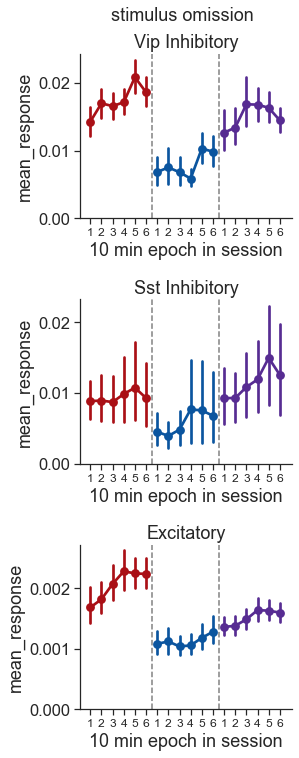

In [30]:
xticks = [experience_epoch.split(' ')[-1] for experience_epoch in np.sort(df.experience_epoch.unique())]

palette = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(4.5,10.5), sharex=False, sharey=False)

for i,cell_type in enumerate(cell_types):
    data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=data, x='experience_epoch', y='mean_response', hue='experience_level',
                       order=experience_epoch, palette=palette, ax=ax[i])
    ax[i].set_ylim(ymin=0)
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
#     ax[i].set_ylim(0,0.022)
#     ax[i].set_xticklabels(experience_epoch, rotation=90);
    ax[i].set_xticklabels(xticks, fontsize=12)
    ax[i].vlines(x=5.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].vlines(x=11.5, ymin=0, ymax=1, color='gray', linestyle='--')
    ax[i].set_xlabel('10 min epoch in session')
plt.suptitle('stimulus omission', x=0.61, y=1.01, fontsize=18)
fig.tight_layout()

### population averages

In [13]:
%%time

# set various params
df_name = 'omission_response_df'
conditions = ['cell_specimen_id']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

# multi_session_df = multi_session_df[multi_session_df.epoch!=6]
multi_session_df = multi_session_df.reset_index(drop=True)


1941
1249
1249
Wall time: 15.1 s


107


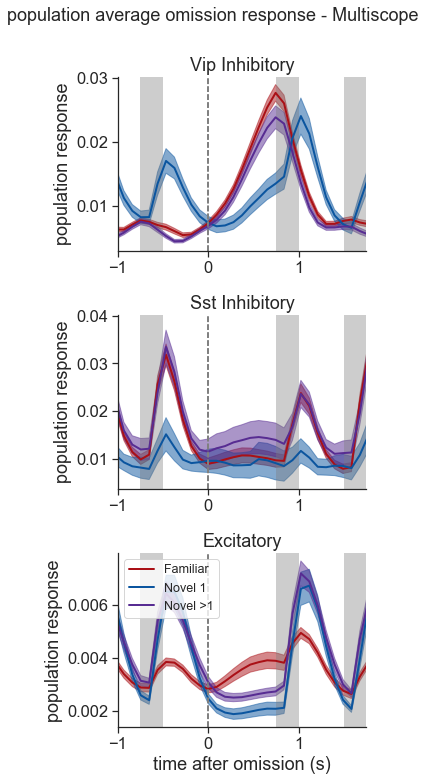

In [15]:
# plot
df = multi_session_df.copy()


project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1,1.75]

tmp = df[df.project_code==project_code]
# df = df[df.experience_level!='Novel >1']
# df = df[df.pref_stim==True]

ppf.plot_population_averages_for_conditions(tmp, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=False, save_dir=None, folder=None)

### limit to containers with all 3 levels for closest active sessions

In [85]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_containers_with_all_experience_levels(df)

In [86]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  15                     30   
               Novel 1                   15                     30   
               Novel >1                  15                     30   
Vip Inhibitory Familiar                  17                     42   
               Novel 1                   17                     42   
               Novel >1                  17                     42   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                7302  
               Novel 1                             62                7974  
               Novel >1                            62                7544  
Sst Inhibitory Familiar                            30                 321  
               Novel 1                             30                 337  
               Novel >1                            30                 320  
Vip Inhibitory Familiar                            42                 794  
               Novel 1                             42                 718  
               Novel >1                            42                 765

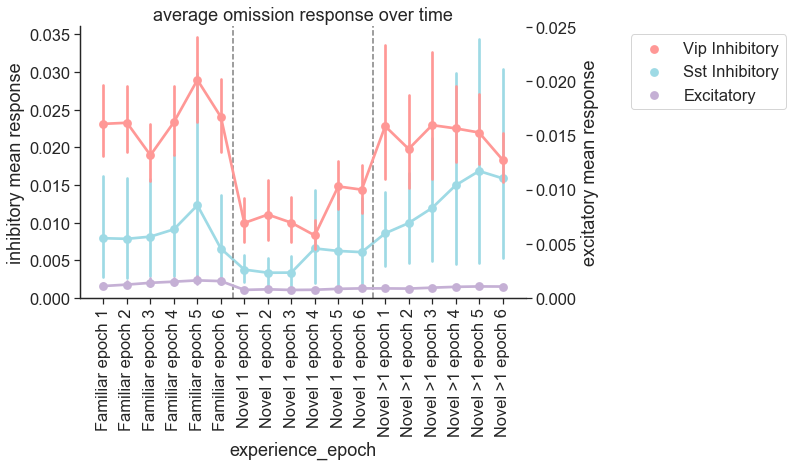

In [87]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average omission response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to matched cells in all 3

In [88]:
df = multi_session_df.copy()
df = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(df)

In [89]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  36                    226   
               Novel 1                   36                     71   
               Novel >1                  36                    142   
Sst Inhibitory Familiar                  15                    112   
               Novel 1                   15                     36   
               Novel >1                  15                     84   
Vip Inhibitory Familiar                  17                    137   
               Novel 1                   17                     44   
               Novel >1                  17                     96   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            71                5695  
               Novel 1                             71                5695  
               Novel >1                            71                5695  
Sst Inhibitory Familiar                            36                 292  
               Novel 1                             36                 292  
               Novel >1                            36                 292  
Vip Inhibitory Familiar                            44                 540  
               Novel 1                             44                 540  
               Novel >1                            44                 540

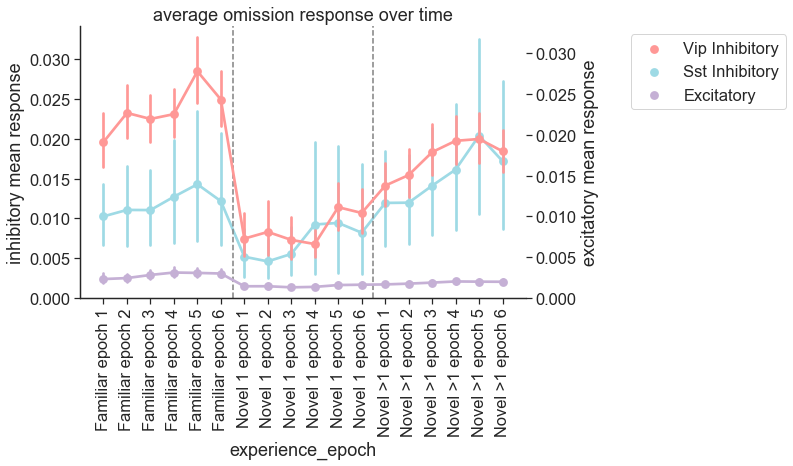

In [90]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average omission response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to matched cells in closest active sessions

In [91]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(df)

In [92]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  14                     28   
               Novel 1                   14                     28   
               Novel >1                  14                     28   
Vip Inhibitory Familiar                  17                     41   
               Novel 1                   17                     41   
               Novel >1                  17                     41   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                3326  
               Novel 1                             62                3326  
               Novel >1                            62                3326  
Sst Inhibitory Familiar                            28                 200  
               Novel 1                             28                 200  
               Novel >1                            28                 200  
Vip Inhibitory Familiar                            41                 415  
               Novel 1                             41                 415  
               Novel >1                            41                 415

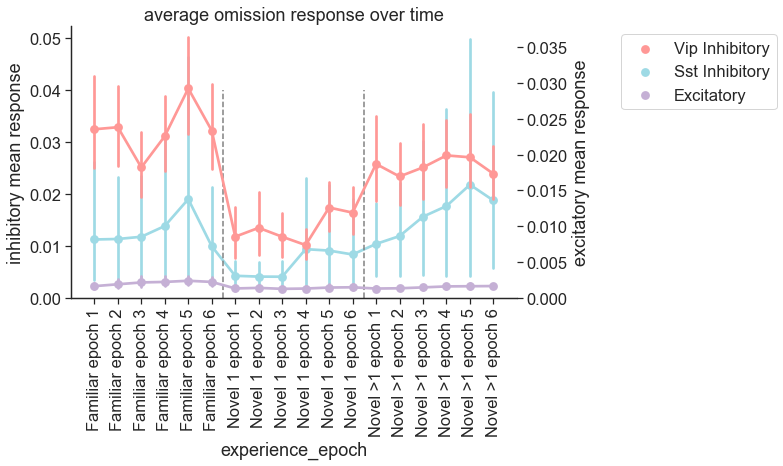

In [93]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average omission response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### heatmap of all mice epoch level responses

In [94]:
df = multi_session_df.copy()
df = df[df.project_code=='VisualBehaviorMultiscope']
# df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_containers_with_all_experience_levels(df)

In [95]:
df = df.sort_values(by=['experience_level', 'mouse_id'])

In [96]:
data = df[df.epoch!=6].copy() # get rid of weird last epoch
data = data.groupby(['experience_level', 'epoch', 'cell_type', 'mouse_id', ]).mean()[['mean_response']].unstack(level=[0,1])
data.columns = data.columns.droplevel()

#### by mouse_id

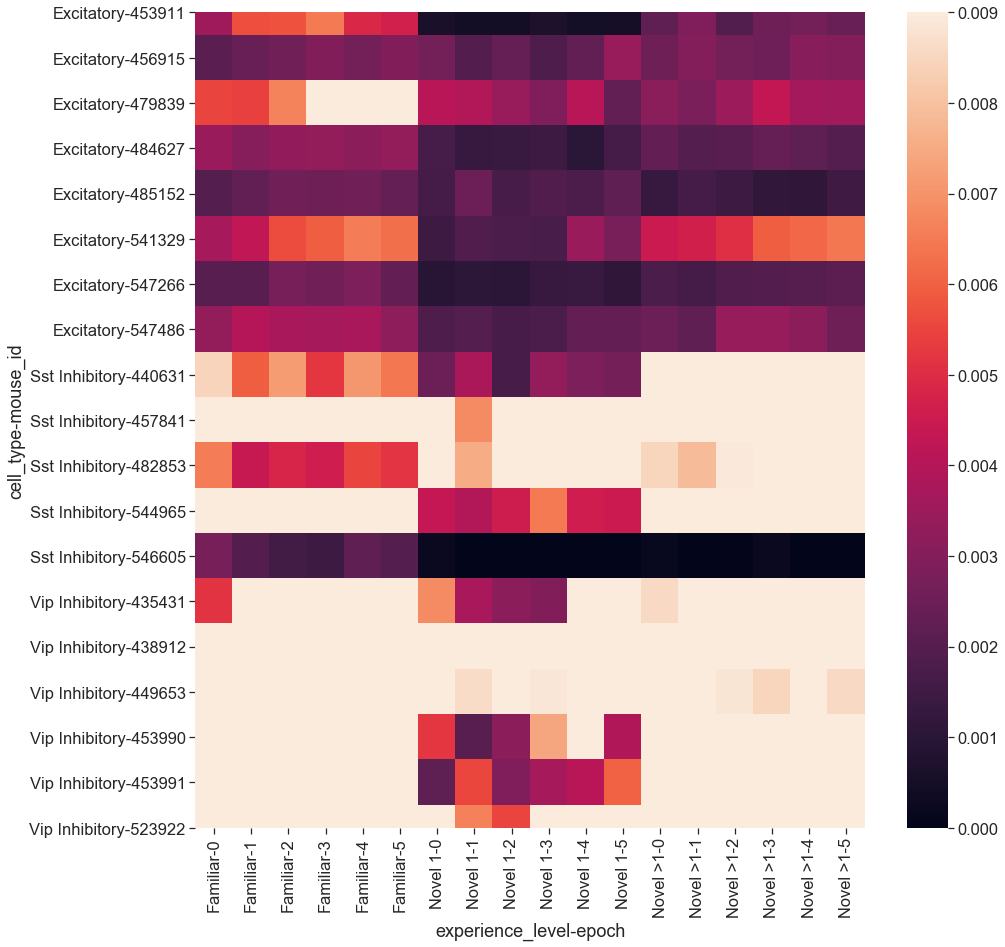

In [97]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(data, vmin=0, vmax=0.009, ax=ax)

### split by area and depth

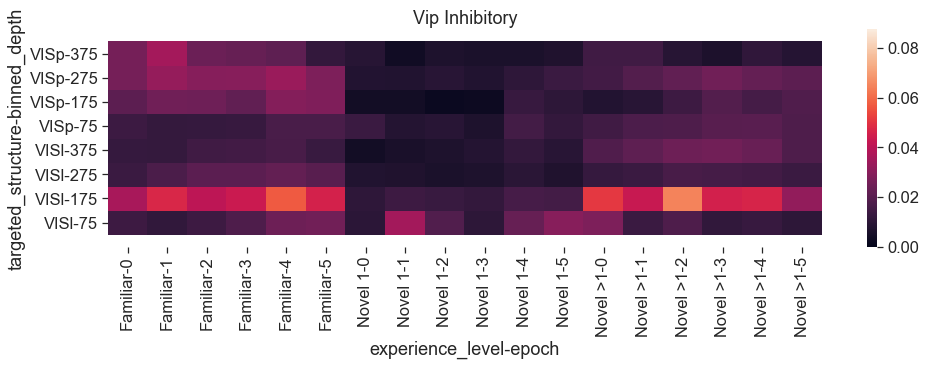

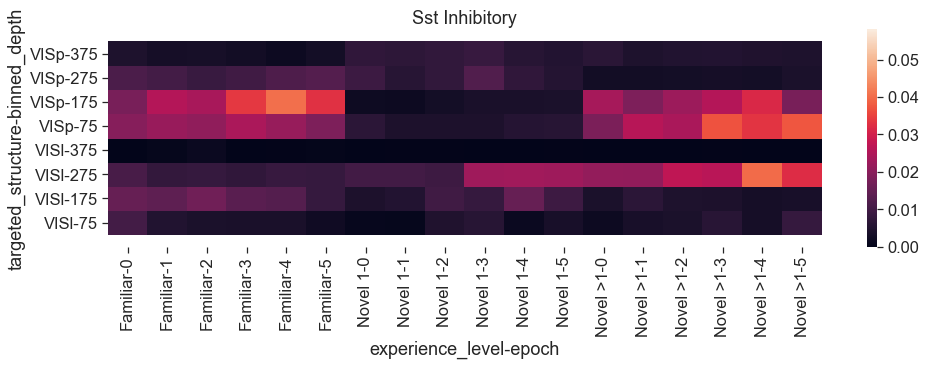

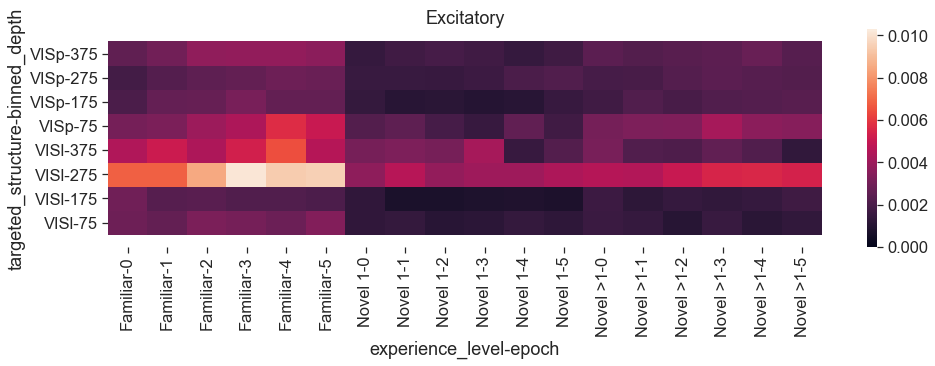

In [98]:
conditions = ['experience_level', 'epoch', 'targeted_structure', 'binned_depth']
for cell_type in cell_types:
    # avg over mice
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0,1])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)